In [1]:
suppressMessages(library(ggView))
suppressMessages(library(MAGeCKFlute))
suppressMessages(library(ggplot2))
suppressMessages(library(ggvenn))
suppressMessages(library(ComplexHeatmap))
options(stringsAsFactors = FALSE)

In [2]:
preds = readRDS("data/Predictions.rds")
preds = preds[order(-preds$MAPD.score), ]
FeatureDat = readRDS("data/Features_Imputed.rds")
Degradability = readRDS("data/Donovan_Degradability.rds")
Kinases = rownames(preds)[preds$IsKinase=="Yes"]
PROTAC = rownames(preds)[preds$PROTACdb=="Yes" | preds$PROTACpedia=="Yes"]


65 PROTAC targets\n(PROTAC-DBs)    801 Drug targets\n(DrugBank) 
                             65                             801 

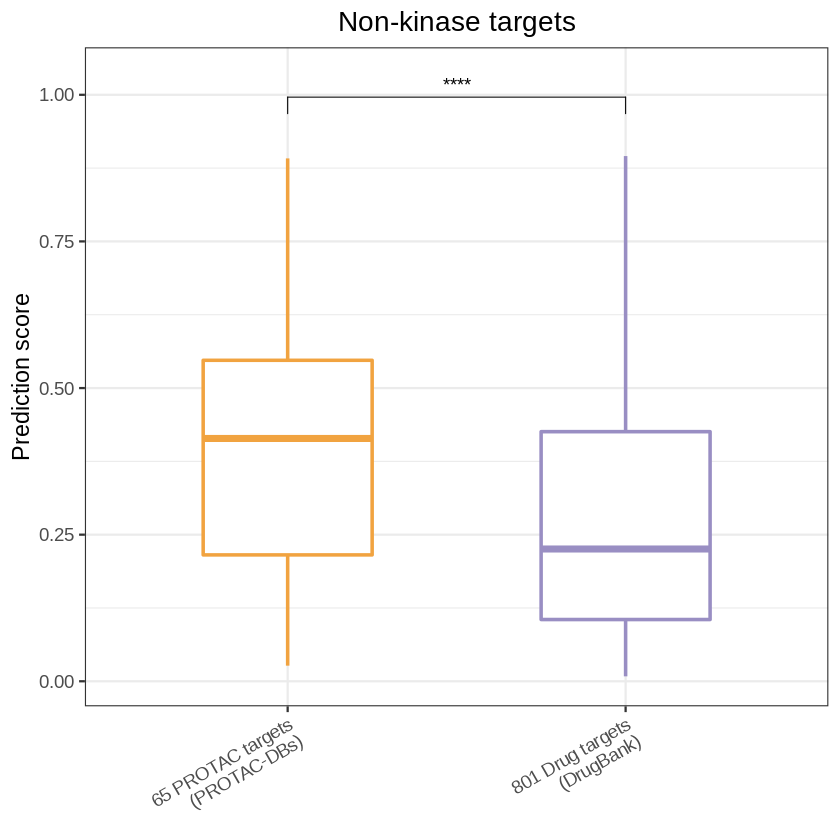

In [3]:
gg = as.data.frame(preds)
gg$Group = NA
gg = gg[gg$IsKinase=="No", ]
gg$Group[gg$DrugBank=="Yes"] = "801 Drug targets\n(DrugBank)"
gg$Group[rownames(gg)%in%PROTAC] = "65 PROTAC targets\n(PROTAC-DBs)"
gg = gg[!is.na(gg$Group), ]
gg$Group = factor(gg$Group, levels = c("65 PROTAC targets\n(PROTAC-DBs)", "801 Drug targets\n(DrugBank)"))
table(gg$Group)
p = BoxView(gg, "Group", "MAPD.score", color = "Group", alpha =1,
            xlab = NULL, ylab = "Prediction score", main = "Non-kinase targets", 
            add.jitter = FALSE, comparisons = list(c("65 PROTAC targets\n(PROTAC-DBs)",
                                                     "801 Drug targets\n(DrugBank)")))
p = p + scale_color_manual(values = c("#f1a340", "#998ec3"))
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))
p = p + ylim(NA, 1.03)
p

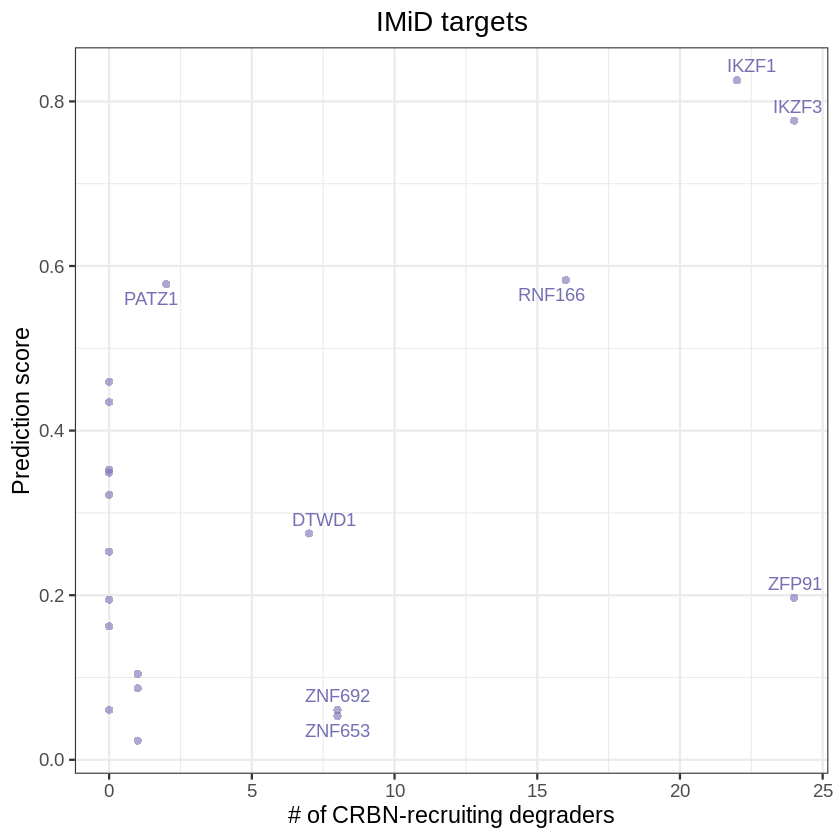

In [4]:
IMiD_targets = c("RNF166", "DTWD1", "E4F1", "IKZF1", "IKZF3", "ZFP91", "ZNF276", "ZNF517", 
                 "ZNF582", "ZNF653", "ZNF654", "ZNF287", "ZNF692", "ZNF787", "ZNF827", "RAB28",
                 "FAM83F", "GZF1", "ZBTB39", "ZNF98", "PATZ1", "ZKSC5", "IKZF2", "IKZF4")
gg1 = as.data.frame(preds[IMiD_targets, ])
gg1$Gene = rownames(gg1)
gg2 = Degradability[, c("Gene", "CRBNDegradeFreq", "CRBNDetectFreq", "MinLFC")]
gg = merge(gg1, gg2, by = "Gene")
gg = gg[gg$CRBNDetectFreq>0, ]

p = ScatterView(gg, "CRBNDegradeFreq", "MAPD.score", label = "Gene", main = "IMiD targets", size = 2,
                toplabels = gg$Gene[gg$CRBNDegradeFreq>2|gg$MAPD.score>0.5], color = "#7570b3")
p = p + labs(x = "# of CRBN-recruiting degraders", y = "Prediction score")
p = p + theme_bw(base_size = 14)
p = p + theme(plot.title = element_text(hjust = 0.5), legend.position = "none")
p

[1] 114

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



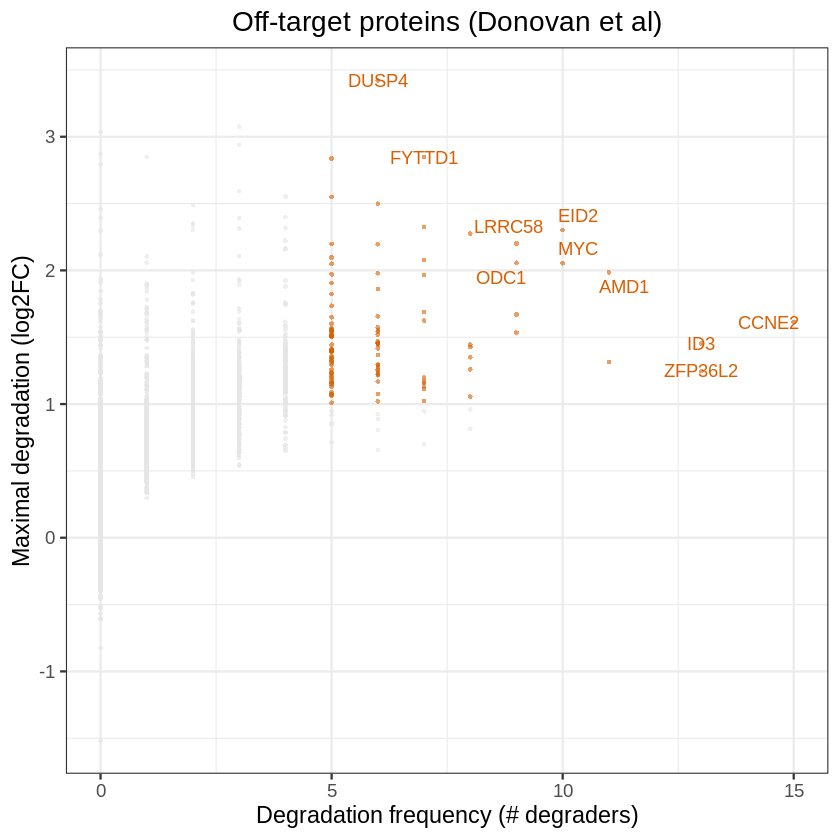

In [5]:
gg = Degradability[!Degradability$Gene%in%c(Kinases, IMiD_targets, PROTAC), ]
Offtargets = gg$Gene[gg$UniqDegradeFreq>4 & gg$MinLFC>1]
length(Offtargets)
p = ScatterView(gg, "UniqDegradeFreq", "MinLFC", main = "Off-target proteins (Donovan et al)",
                x_cut = 4, y_cut = 1, groups = "topright", top = 10,
                xlab = "Degradation frequency (# degraders)", ylab = "Maximal degradation (log2FC)")
p = p + scale_color_manual(values = c("#d95f02", "gray90"))
p = p + theme_bw(base_size = 14)
p = p + theme(plot.title = element_text(hjust = 0.5), legend.position = "none")
p

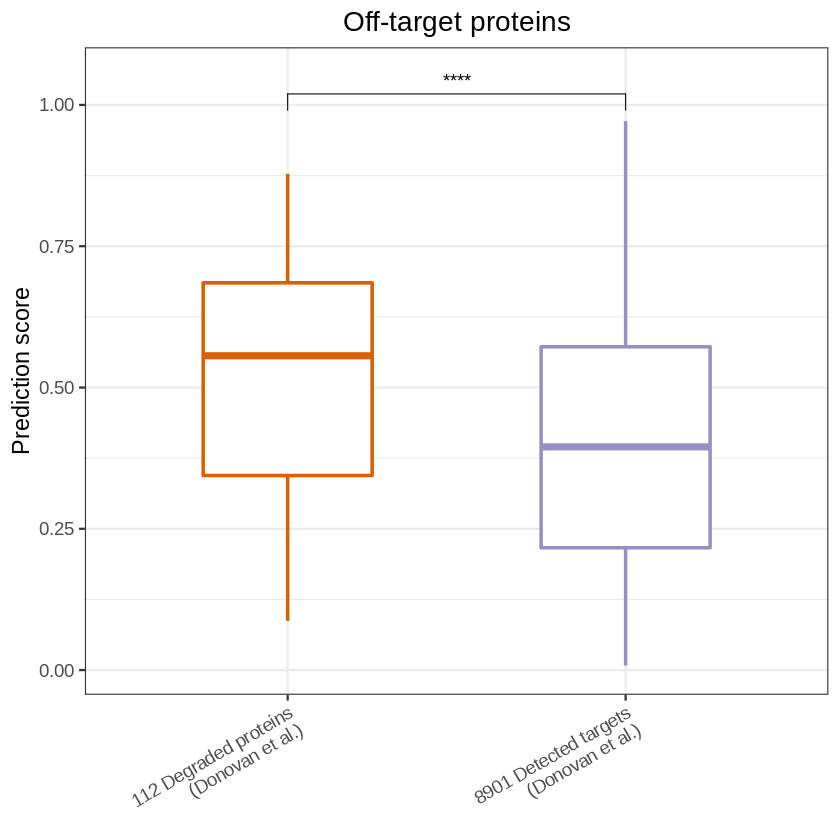

In [6]:
gg = preds[setdiff(Degradability$Gene, c(Kinases, IMiD_targets, PROTAC)), ]
gg$Degraded = NA
gg$Degraded[rownames(gg)%in%Degradability$Gene[Degradability$DetectFreq>15]] = "No"
othertargets = Degradability$Gene[Degradability$UniqDegradeFreq>4 & Degradability$MinLFC>1]
gg$Degraded[rownames(gg)%in%c(othertargets)] = "Yes"
gg = na.omit(gg)
gg$Degraded[gg$Degraded=="No"] = paste0(sum(gg$Degraded=="No"), " Detected targets\n(Donovan et al.)")
gg$Degraded[gg$Degraded=="Yes"] = paste0(sum(gg$Degraded=="Yes"), " Degraded proteins\n(Donovan et al.)")
gg$Degraded = factor(gg$Degraded, levels = sort(unique(gg$Degraded)))
p = BoxView(gg, "Degraded", "MAPD.score", color = "Degraded", alpha =1,
            xlab = NULL, ylab = "Prediction score", main = "Off-target proteins", 
            add.jitter = FALSE, comparisons = list(levels(gg$Degraded)))
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))
p = p + scale_color_manual(values = c("#d95f02", "#998ec3"))
p = p + ylim(NA, 1.05)
p

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



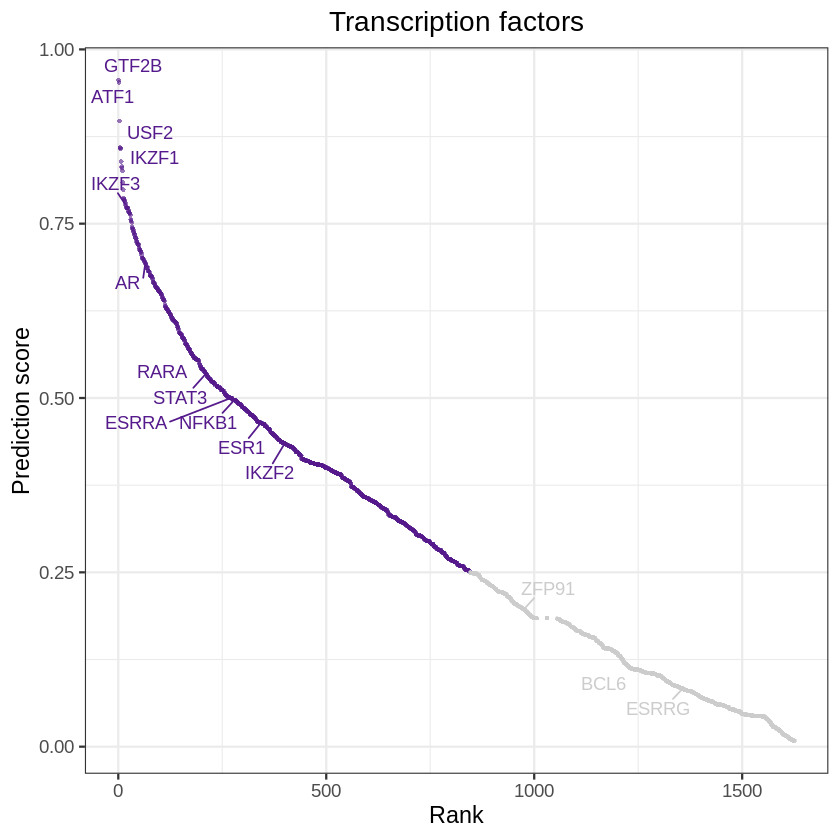

In [7]:
gg = preds[preds$TF=="Yes", ]
gg$Rank = rank(-gg$MAPD.score)
p = ScatterView(gg, "Rank", "MAPD.score", y_cut = 0.25, groups = "top", max.overlaps = Inf,
                ylab = "Prediction score", main = "Transcription factors", top = 3,
                toplabels = c("STAT3", "NFKB1", "IKZF1", "IKZF2", "IKZF3", PROTAC))
p = p + scale_color_manual(values = c("purple4", "gray80"))
p = p + theme_bw(base_size = 14)
p = p + theme(plot.title = element_text(hjust = 0.5), legend.position = "none")
p

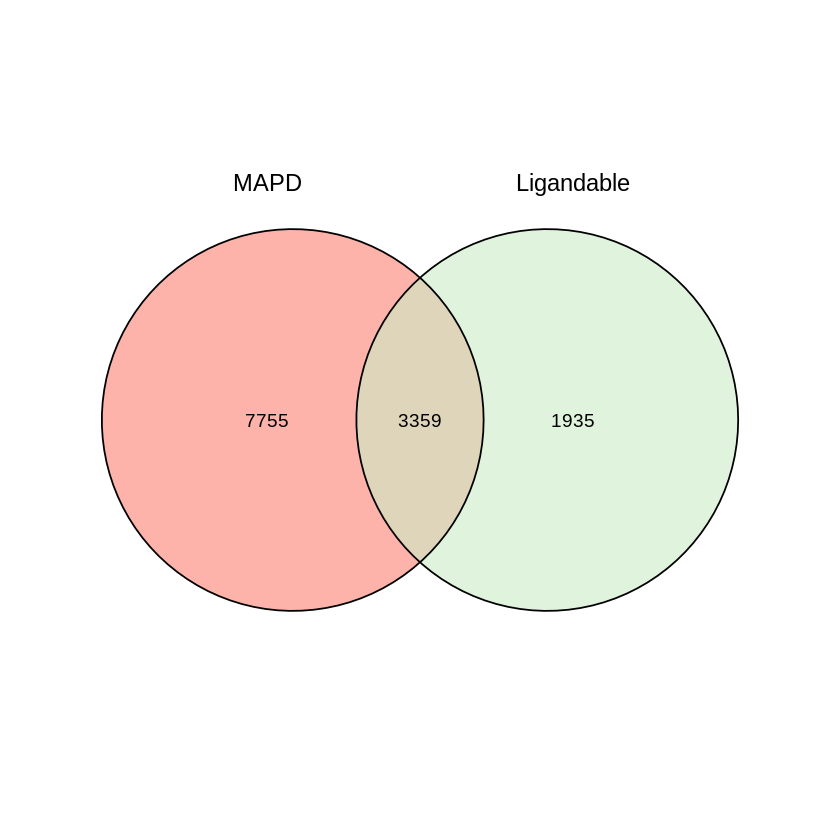

In [8]:
MAPD = rownames(preds)[preds[,1]>=0.2327 & preds$IsKinase=="No"]
ChEMBL = rownames(preds)[preds$ChEMBL=="Yes" & preds$IsKinase=="No"]
SLCABPP = rownames(preds)[preds$Electrophiles>0 & preds$IsKinase=="No"]
DrugBank = rownames(preds)[preds$DrugBank=="Yes" & preds$IsKinase=="No"]

gg = list(MAPD = MAPD, Ligandable = unique(c(ChEMBL, SLCABPP, DrugBank)))
p = ggvenn(gg, fill_color = c("#fb8072", "#ccebc5"), show_percentage = FALSE,
           stroke_size = 0.5, set_name_size = 5, fill_alpha = 0.6)
p

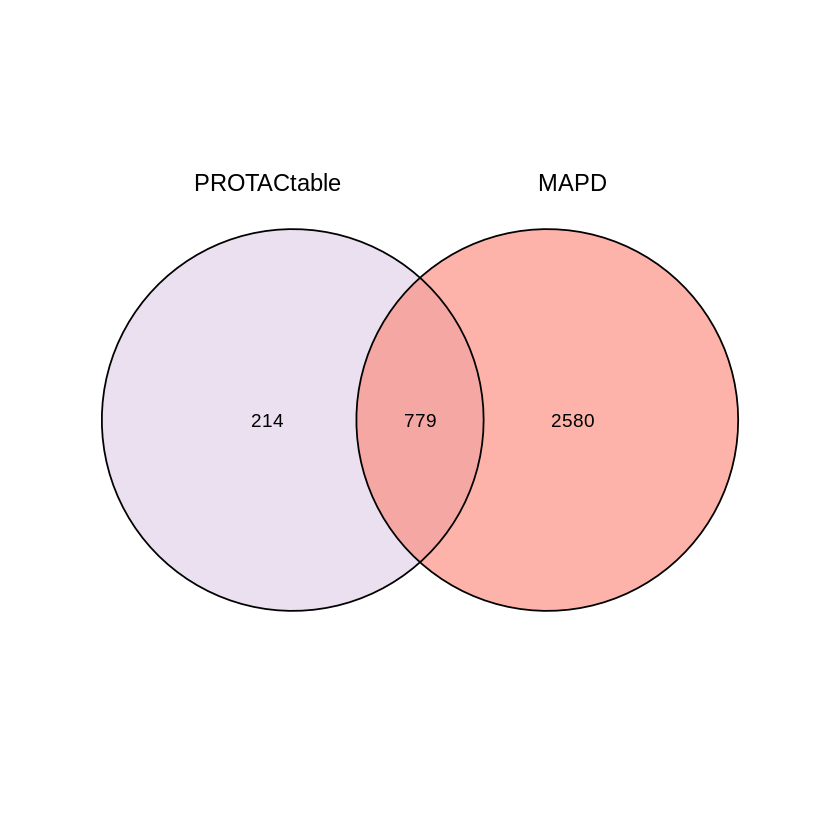

In [9]:
idx = preds$ChEMBL=="Yes"|preds$Electrophiles>0|preds$DegradeFreq>4
MAPD = rownames(preds)[preds[,1]>=0.2327 & preds$IsKinase=="No"]
PROTACtable = rownames(preds)[preds$PROTACtable=="Yes" & preds$IsKinase=="No"]
ChEMBL = rownames(preds)[preds$ChEMBL=="Yes" & preds$IsKinase=="No"]
SLCABPP = rownames(preds)[preds$Electrophiles>0 & preds$IsKinase=="No"]
DrugBank = rownames(preds)[preds$DrugBank=="Yes" & preds$IsKinase=="No"]
Donovan = setdiff(Degradability$Gene[Degradability$DegradeFreq>4], Kinases)
Ligandable = unique(c(ChEMBL, SLCABPP, DrugBank))
MAPD = intersect(MAPD, Ligandable)
gg = list(PROTACtable = PROTACtable, MAPD = MAPD)
p = ggvenn(gg, fill_color = c("#decbe4", "#fb8072"), show_percentage = FALSE,
           stroke_size = 0.5, set_name_size = 5, fill_alpha = 0.6)
p

Warning message in if (is.na(fill)) boo2 = TRUE:
“the condition has length > 1 and only the first element will be used”
Warning message in if (fill %in% colnames(gg)) p = p + geom_boxplot(aes_string(fill = fill), :
“the condition has length > 1 and only the first element will be used”


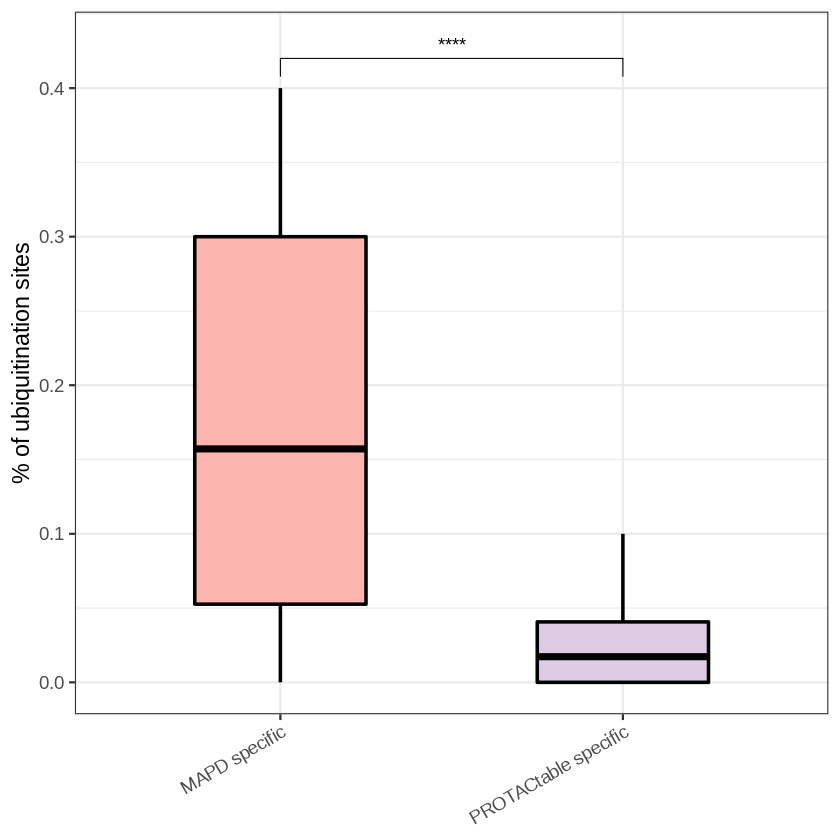

In [10]:
idx = preds$ChEMBL=="Yes"|preds$Electrophiles>0|preds$DegradeFreq>4
MAPD = rownames(preds)[preds[,1]>=0.2327 & preds$IsKinase=="No"]
PROTACtable = rownames(preds)[preds$PROTACtable=="Yes" & preds$IsKinase=="No"]
ChEMBL = rownames(preds)[preds$ChEMBL=="Yes" & preds$IsKinase=="No"]
SLCABPP = rownames(preds)[preds$Electrophiles>0 & preds$IsKinase=="No"]
DrugBank = rownames(preds)[preds$DrugBank=="Yes" & preds$IsKinase=="No"]
Donovan = setdiff(Degradability$Gene[Degradability$DegradeFreq>4], Kinases)
Ligandable = unique(c(ChEMBL, SLCABPP, DrugBank))
MAPD = intersect(MAPD, Ligandable)
MAPD_specific = setdiff(MAPD, PROTACtable)
PROTACtable_specific = setdiff(PROTACtable, MAPD)
gg = FeatureDat[c(MAPD_specific, PROTACtable_specific), ]
gg$Group = "MAPD specific"
gg$Group[rownames(gg)%in%PROTACtable_specific] = "PROTACtable specific"
gg = gg[gg$Detectability>0.1, ]
gg$Ubiquitination_2[gg$Ubiquitination_2>0.4] = 0.4
p = BoxView(gg, "Group", "Ubiquitination_2", comparisons = list(c("MAPD specific", "PROTACtable specific")),
            fill = c("#fbb4ae", "#decbe4"), xlab = NULL, ylab = "% of ubiquitination sites")
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))
p = p + ylim(NA, 0.43)
p

,MAPD.score,PROTACdb,PROTACpedia,PROTACtable,DrugBank,ChEMBL,Electrophiles,TF,Oncogene,Clinvar
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
KEAP1,0.83505,No,No,Yes,Yes,Yes,35,No,No,No
PPIA,0.71260,No,No,Yes,Yes,Yes,12,No,No,No
TP53,0.71035,No,No,No,No,Yes,6,Yes,No,Yes
PCBP1,0.69420,No,No,No,No,Yes,7,No,Yes,Yes
AR,0.69335,Yes,Yes,Yes,Yes,Yes,0,Yes,No,Yes
FKBP1A,0.69125,No,Yes,Yes,Yes,Yes,0,No,No,No


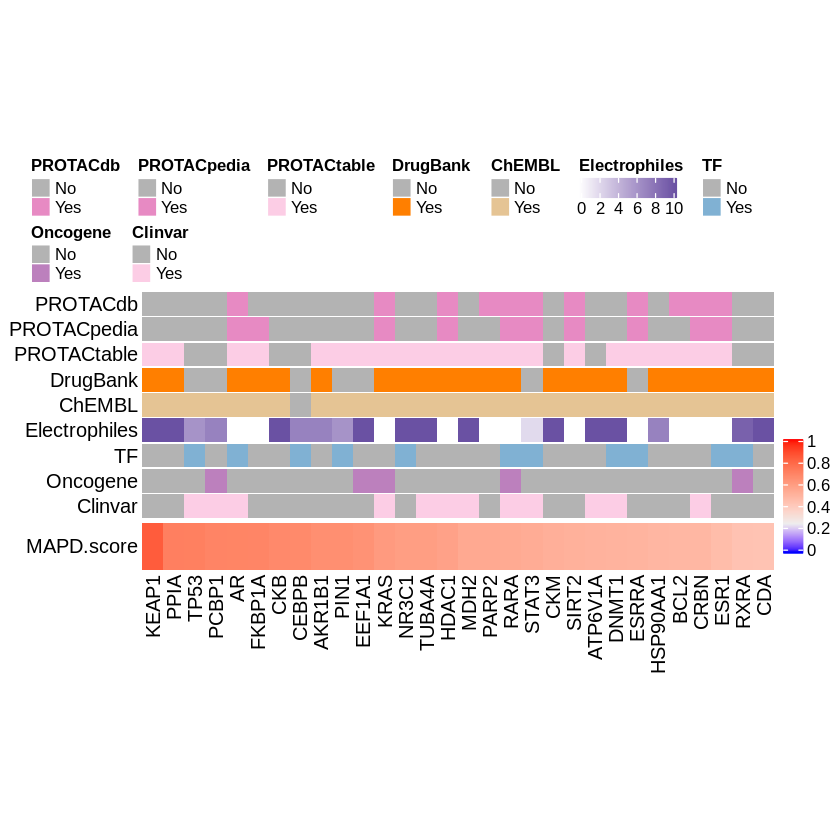

In [11]:
idx1 = preds$DrugBank=="Yes" | preds$TF=="Yes" | preds$Oncogene=="Yes"
idx2 = preds$PROTACdb=="Yes" | preds$PROTACpedia=="Yes" | preds$Multi.kinase.degrader=="Yes" | preds$Electrophiles>5
KinGG = preds[preds$IsKinase=="No" & idx1 & idx2, ][1:30, -c(2:5,8)]
head(KinGG)

col = circlize::colorRamp2(c(0, 0.25, 1), c("blue", "#EEEEEE", "red"))
ha = HeatmapAnnotation(df = KinGG[,-1], annotation_name_side = "left",
                       col = list("PROTACdb" = c("Yes" = "#e78ac3", "No" = "#b3b3b3"),
                                  "PROTACpedia" = c("Yes" = "#e78ac3", "No" = "#b3b3b3"),
                                  "Multi.kinase.degrader" = c("Yes" = "#66c2a5", "No" = "#b3b3b3"),
                                  "PROTACtable" = c("Yes" =  "#fccde5", "No" = "#b3b3b3"),
                                  "DrugBank" = c("Yes" =  "#ff7f00", "No" = "#b3b3b3"),
                                  "ChEMBL" = c("Yes" =  "#e5c494", "No" = "#b3b3b3"),
                                  "Electrophiles" = circlize::colorRamp2(seq(0, 10, length = 2), c("white", "#6a51a3")),
                                  "TF" = c("Yes" =  "#80b1d3", "No" = "#b3b3b3"),
                                  "Oncogene" = c("Yes" =  "#bc80bd", "No" = "#b3b3b3"),
                                  "Clinvar" = c("Yes" =  "#fccde5", "No" = "#b3b3b3")),
                      annotation_legend_param = list("Electrophiles" = list(direction = "horizontal")))
p = Heatmap(t(KinGG[,1,drop=FALSE]), col = col, name = " ", row_names_side = "left", 
            cluster_columns = FALSE, top_annotation = ha, height = unit(1, "cm"))
draw(p, annotation_legend_side = "top")